"""
Copyright 2026 Zsolt Bedőházi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
import ast
import shutil
from omegaconf import OmegaConf
import h5py
import joblib
from openslide import OpenSlide

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from sklearn.metrics import silhouette_score
import plotly.express as px
from sklearn.cluster import DBSCAN

In [2]:
# Load config
preproc_conf = OmegaConf.load("../conf/preproc.yaml")
preproc_conf = preproc_conf['classic_mil_on_embeddings_bag']['jmcs_224_224_patches']

## Get tables for NG

#### load merged_df_latest.csv that was generated earlier in "generate_multi_strat_common_test.ipynb" and it is already filtered, cleaned

In [3]:
merged_df_latest = pd.read_csv("merged_df_latest.csv", index_col=0)

In [4]:
merged_df_latest.shape

(804, 45)

In [ ]:
merged_df_latest.head(2)

#### Load final_df.csv, representing the new rev study cohort

In [6]:
final_df = pd.read_csv("cv_splits_multi_stratified_sklearn_s_a_r_mo_paper_patients_rev/final_df.csv")

In [7]:
final_df.shape

(575, 15)

In [8]:
Counter(final_df.Pathological.values)

Counter({np.int64(1): 479, np.int64(2): 70, np.int64(3): 26})

In [9]:
merged_df_latest = merged_df_latest[merged_df_latest.patient_ngsci_id.isin(final_df.patient_ngsci_id.values)]

In [10]:
merged_df_latest.shape

(715, 45)

In [11]:
merged_df_latest['biopsy_id'].nunique()

715

In [12]:
merged_df_latest['patient_ngsci_id'].nunique()

575

## Get tables for Semmelweis

In [13]:
biopsy_df_sote = pd.read_csv("private_external_test_set/biopsy_df.csv")
labels_df_sote = pd.read_csv("private_external_test_set/labels_df.csv")

In [14]:
biopsy_df_sote.shape, labels_df_sote.shape

((286, 17), (329, 18))

## Get tables for TCGA-BRCA

In [15]:
biopsy_df_tcga = pd.read_csv("tcga_brca_test_set//biopsy_df.csv")
labels_df_tcga = pd.read_csv("tcga_brca_test_set/labels_df.csv")

In [16]:
biopsy_df_tcga.shape, labels_df_tcga.shape

((678, 2), (731, 3))

## Embeddings

In [17]:
# Merge on patient_ngsci_id
merged_df_latest = merged_df_latest.merge(
    final_df[['patient_ngsci_id', 'Pathological']],
    on='patient_ngsci_id',
    how='left'  # or 'inner' depending on your use case
)

In [18]:
merged_df_latest.shape

(715, 46)

In [ ]:
# Nightingale (NG)
"<YOUR_PATH>/02_patch_embeddings/uni_finetuned_embs_1024_level4_macenko_improved_v2/"                      # slide level
"<YOUR_PATH>/02_patch_embeddings/uni_finetuned_biopsy_1024_level4_macenko_improved_v2_biopsies_rev"        # biopsy level
"<YOUR_PATH>/02_patch_embeddings/uni_finetuned_biopsy_1024_level4_macenko_improved_v2_patients_rev/"       # patient level

# Semmelweis
"<YOUR_PATH>/02_patch_embeddings/classic_mil/uni_finetuned_embs_1024_level_4_224_macenko_new_bracs/"          # slide level
"<YOUR_PATH>/04_embeddings_biopsy_bags/classic_mil/uni_finetuned_biopsy_1024_level_4_224_macenko_new_bracs/"  # patient level

# TCGA-BRCA
"<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/patch_embeddings/uni_finetuned_embs_1024_level4_macenko/"       # slide level
"<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/patch_embeddings/uni_finetuned_biopsy_1024_level4_macenko/"     # patient level


In [20]:
def reduce_embeddings(X, method="pca"):
    X_scaled = StandardScaler().fit_transform(X)
    
    if method == "pca":
        model = PCA(n_components=2)
    elif method == "tsne":
        model = TSNE(n_components=2, perplexity=30, random_state=42)
    elif method == "umap":
        model = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Unknown method")
    
    return model.fit_transform(X_scaled)

In [21]:
def plot_2d_single_dataset(X_2d, meta_df, title, method, legend_loc="lower left", save_fig=False, save_path=None):

    # Method label mapping
    method_labels = {
        "pca": "PCA",
        "tsne": "t-SNE",
        "umap": "UMAP"
    }
    method_label = method_labels.get(method.lower(), method.upper())

    # Legend position mapping
    legend_positions = {
        "lower left":  {"loc": "lower left",  "bbox": (0.02, 0.02)},
        "lower right": {"loc": "lower right", "bbox": (0.98, 0.02)},
        "upper left":  {"loc": "upper left",  "bbox": (0.02, 0.98)},
        "upper right": {"loc": "upper right", "bbox": (0.98, 0.98)},
    }
    legend_config = legend_positions.get(legend_loc.lower(), legend_positions["lower left"])

    # Prepare data
    plot_df = pd.DataFrame(X_2d, columns=["x", "y"])
    stage_map = {"1": "Stage I", "2": "Stage II", "3": "Stage III"}
    plot_df["Stage"] = meta_df["stage"].astype(str).map(stage_map)

    # Stage color palette
    stage_order = ["Stage I", "Stage II", "Stage III"]
    stage_palette = {
        "Stage I": "#6495ED",   # Blue
        "Stage II": "#FFA500",  # Orange
        "Stage III": "#FF0000"  # Red
    }

    plt.figure(figsize=(8, 6))
    sns.set(style="white")

    scatter = sns.scatterplot(
        data=plot_df,
        x="x", y="y",
        hue="Stage", hue_order=stage_order, palette=stage_palette,
        s=70, alpha=0.60
    )

    # Axis labels
    plt.xlabel(f"{method_label} 1", fontsize=12)
    plt.ylabel(f"{method_label} 2", fontsize=12)

    # Title
    plt.title(title, fontsize=16, weight='bold')

    # Legend
    handles, labels = scatter.get_legend_handles_labels()
    stage_handles = [h for h, l in zip(handles, labels) if l in stage_order]
    plt.legend(
        handles=stage_handles,
        labels=stage_order,
        loc=legend_config["loc"],
        bbox_to_anchor=legend_config["bbox"],
        fontsize=12,
        frameon=True
    )

    # Styling
    plt.grid(False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save figure
    if save_fig and save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", bbox_inches="tight")

    plt.show()


## SLIDE LEVEL

In [ ]:
# -------------------------
# PATHS TO SLIDE EMBEDDINGS
# -------------------------
ng_slide_dir = "<YOUR_PATH>/02_patch_embeddings/uni_finetuned_embs_1024_level4_macenko_improved_v2/"
sem_slide_dir = "<YOUR_PATH>/02_patch_embeddings/classic_mil/uni_finetuned_embs_1024_level_4_224_macenko_new_bracs/"
tcga_slide_dir = "<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/patch_embeddings/uni_finetuned_embs_1024_level4_macenko/"

In [23]:
def load_slide_embedding(h5_path):
    with h5py.File(h5_path, "r") as f:
        features = f["features"][()]
        return np.mean(features, axis=0)  # Mean aggregation

In [24]:
def load_slide_dataset(slide_dir, id_list, stage_dict, dataset_name):
    features, ids, stages, datasets = [], [], [], []

    for sid in tqdm(id_list):
        fname = f"{sid}.h5" if not sid.endswith(".h5") else sid
        fpath = os.path.join(slide_dir, fname)
        if not os.path.exists(fpath):
            continue
        try:
            emb = load_slide_embedding(fpath)
            stage = stage_dict.get(fname)
            if stage is not None:
                features.append(emb)
                ids.append(fname)
                stages.append(stage)
                datasets.append(dataset_name)
        except Exception as e:
            print(f"Error: {sid} → {e}")
    
    return pd.DataFrame(features), pd.DataFrame({
        "slide_id": ids,
        "stage": stages,
        "dataset": datasets
    })

In [25]:
# NG — slide_id list from merged_df_latest["slide_id"]
slide_dict_ng = {}
for _, row in merged_df_latest.iterrows():
    stage = row["Pathological"]
    slide_ids = eval(row["slide_id"])  # Assuming it's stored as stringified list
    for sid in slide_ids:
        slide_dict_ng[sid + ".h5"] = stage
ng_slide_ids = list(slide_dict_ng.keys())

# Semmelweis
sem_slide_dict = dict(zip(labels_df_sote["slide_id"], labels_df_sote["clinical_stage"]))
sem_slide_ids = list(sem_slide_dict.keys())

# TCGA
tcga_slide_dict = dict(zip(labels_df_tcga["slide_id"]+".h5", labels_df_tcga["stage"]))
tcga_slide_ids = list(tcga_slide_dict.keys())

#### save slide embedding data for faster loading

#### load slide embedding data for faster loading

In [26]:
X_slide, meta_slide = joblib.load('slide_embeddings_data.pkl')

In [27]:
X_slide.shape

(11889, 1024)

In [28]:
meta_slide.shape

(11889, 3)

### SLIDE LEVEL - individual datasets - Nightingale - tsne

In [29]:
def plot_slide_embeddings_for_dataset(X_slide, meta_slide, title, dataset_name, method="tsne",
                                      save_fig=False, save_path=None, legend_loc="lower left"):
    """
    Filter slide-level embeddings and metadata for a single dataset, reduce dimensions, and plot.
    """
    import numpy as np

    # Filter for selected dataset
    mask = meta_slide["dataset"] == dataset_name
    X_filtered = X_slide[mask.values]
    meta_filtered = meta_slide[mask].reset_index(drop=True)

    # Dimensionality reduction
    X_red = reduce_embeddings(X_filtered, method=method)

    # Plot
    title = title
    plot_2d_single_dataset(X_red, meta_filtered, title, method,
                           legend_loc=legend_loc, save_fig=save_fig, save_path=save_path)


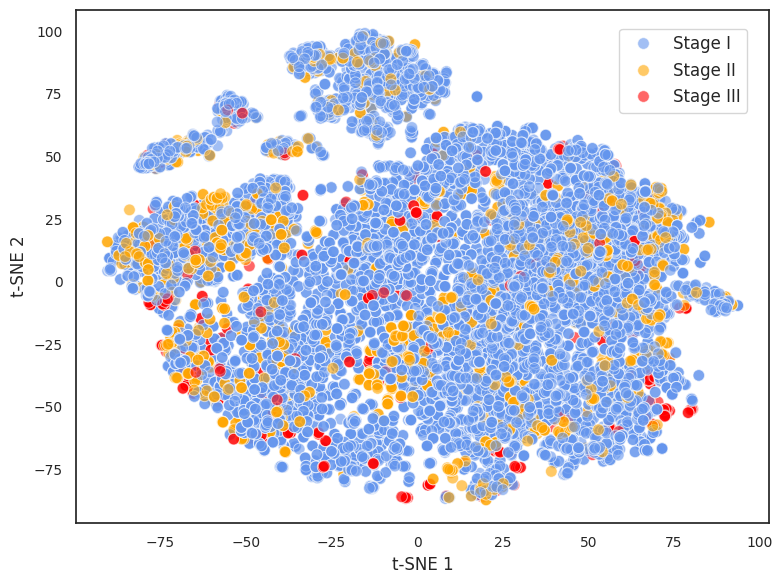

In [30]:
plot_slide_embeddings_for_dataset(
    X_slide, meta_slide,
    title="",
    dataset_name="NG",
    method="tsne",
    save_fig=True,
    save_path="figures/tsne_projection_slide_level_ng_dataset",
    legend_loc="upper right"
)

### SLIDE LEVEL - individual datasets - Nightingale - tsne lymph node filtering

In [31]:
X_slide.shape

(11889, 1024)

In [ ]:
meta_slide.head()

In [33]:
def cluster_tsne_dbscan(X_red, eps=5, min_samples=10):
    """
    Apply DBSCAN to 2D t-SNE data.
    Returns cluster labels (one per point).
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = db.fit_predict(X_red)
    return cluster_labels

In [34]:
mask = meta_slide["dataset"] == "NG"
X_filtered = X_slide[mask.values]
meta_filtered = meta_slide[mask].reset_index(drop=True)

# Dimensionality reduction
X_red_tsne = reduce_embeddings(X_filtered, method="tsne")

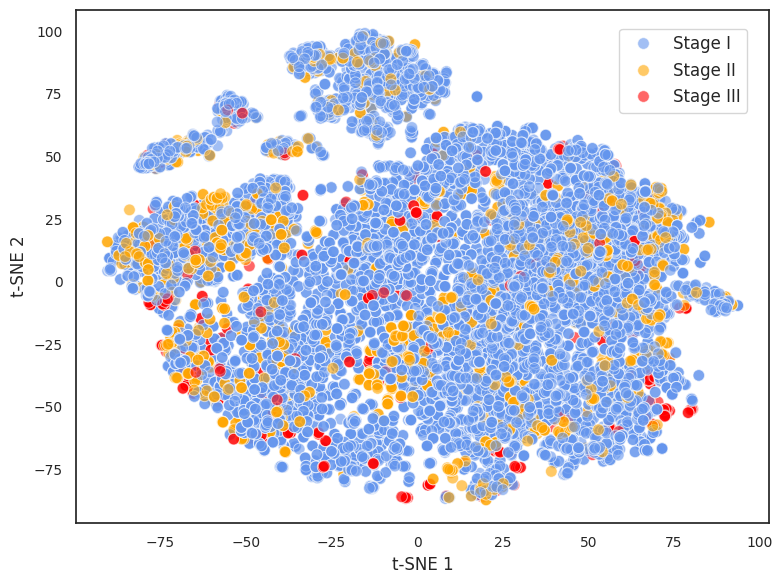

In [35]:
plot_2d_single_dataset(X_red_tsne, meta_filtered, "", "tsne", "upper right", False)

In [36]:
def plot_tsne_clusters(X_red_tsne, meta_df, title="DBSCAN on t-SNE", save_fig=False, save_path=None):
    plot_df = pd.DataFrame(X_red_tsne, columns=["x", "y"])
    plot_df["cluster_tsne"] = meta_df["cluster_tsne"].astype(str)
    
    plt.figure(figsize=(8, 6))
    sns.set(style="white")

    sns.scatterplot(
        data=plot_df,
        x="x", y="y",
        hue="cluster_tsne",
        palette="tab10",
        s=60, alpha=0.8,
        legend="full"
    )

    plt.grid(False)
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    
    # --- Reorder legend so that "-1" is last ---
    handles, labels = plt.gca().get_legend_handles_labels()
    if "-1" in labels:
        idx = labels.index("-1")
        handles.append(handles.pop(idx))
        labels.append(labels.pop(idx))
    plt.legend(handles, labels, title="Cluster")

    plt.tight_layout()
    if save_fig and save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", bbox_inches="tight")

    plt.show()

In [37]:
# Assuming X_red_tsne is the t-SNE output and meta_filtered contains NG slides only
cluster_labels_tsne = cluster_tsne_dbscan(X_red_tsne, eps=5, min_samples=10)
meta_filtered["cluster_tsne"] = cluster_labels_tsne  # Append to metadata

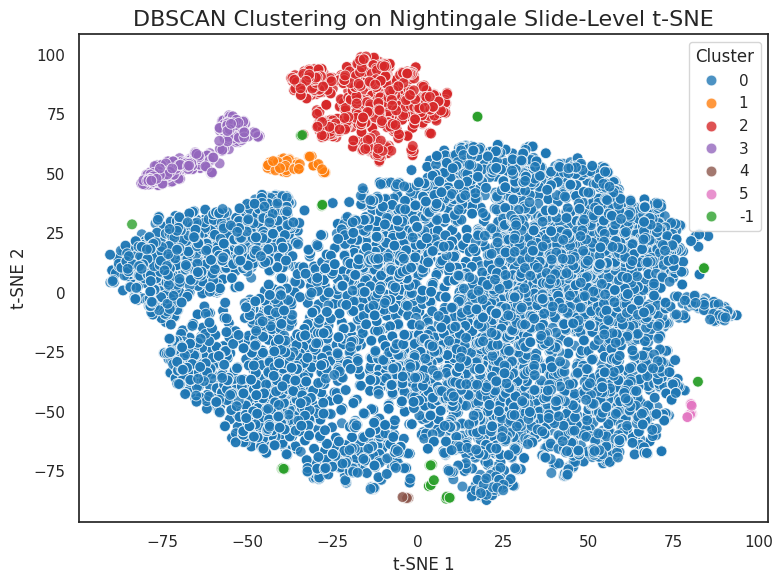

In [38]:
plot_tsne_clusters(X_red_tsne, meta_filtered, title="DBSCAN Clustering on Nightingale Slide-Level t-SNE")

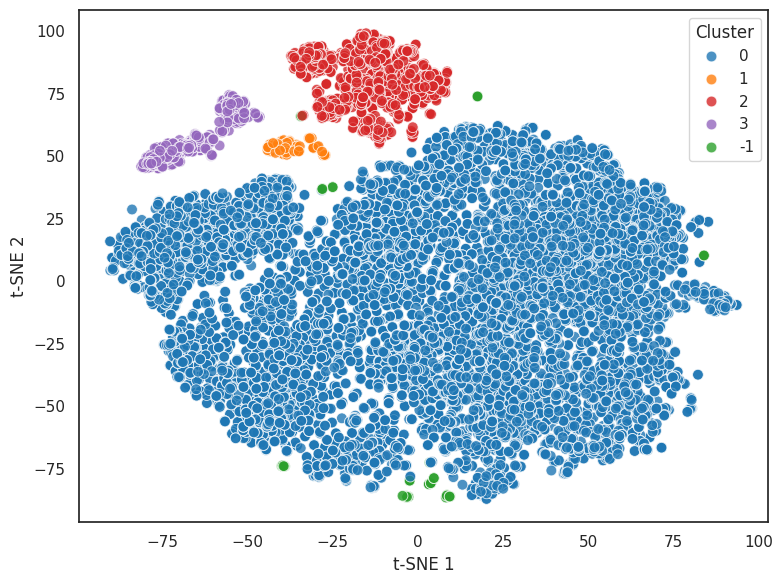

In [39]:
cluster_labels_tsne = cluster_tsne_dbscan(X_red_tsne, eps=5.5, min_samples=14)
meta_filtered["cluster_tsne"] = cluster_labels_tsne
plot_tsne_clusters(X_red_tsne, meta_filtered, title="", save_fig=True, save_path="figures/tsne_projection_slide_level_ng_dataset_dbscan_clusters",)

#### collect representative samples from each cluster

##### cluster 0

In [42]:
meta_filtered.shape, X_red_tsne.shape

((10829, 4), (10829, 2))

In [60]:
indices = np.where((X_red_tsne[:,0] >= -25) & (X_red_tsne[:,0] <= 25) &
                   (X_red_tsne[:,1] >= -25) & (X_red_tsne[:,1] <= 25))[0]
indices

array([    1,     5,    13, ..., 10807, 10820, 10822])

In [64]:
Counter(meta_filtered[meta_filtered.index.isin(indices)].cluster_tsne)

Counter({0: 1290})

In [ ]:
meta_filtered[meta_filtered.index.isin(indices)].sample(n=20, random_state=40)

In [68]:
biopsy_slides_df = pd.read_csv("biopsy-slides.csv")

In [ ]:
slide_openslide = OpenSlide("<YOUR_PATH>/" + biopsy_slides_df[biopsy_slides_df.slide_id=="6b3c4b8a-d6cb-4ac8-bc2a-9d81c0995eae"].slide_path.values[0])

In [ ]:
slide_openslide.get_thumbnail((512,512))

In [107]:
slide_openslide.level_dimensions

((195840, 103680),
 (97920, 51840),
 (48960, 25920),
 (24480, 12960),
 (12240, 6480),
 (6120, 3240),
 (3060, 1620),
 (1530, 810),
 (765, 405))

In [108]:
img_openslide_cluster_0 = slide_openslide.read_region((0, 0), 7, slide_openslide.level_dimensions[7])
img_openslide_cluster_0_RGB = img_openslide_cluster_0.convert("RGB")
img_openslide_cluster_0_RGB.save("ng_qc_samples/6b3c4b8a-d6cb-4ac8-bc2a-9d81c0995eae_cluster_0.png")

##### cluster 1

In [118]:
meta_filtered[meta_filtered.slide_id=="e21fc504-d65d-4aaa-951e-211c64391e54.h5"]

,slide_id,stage,dataset,cluster_tsne
9918,e21fc504-d65d-4aaa-951e-211c64391e54.h5,1,NG,1


In [ ]:
slide_openslide = OpenSlide("<YOUR_PATH>/" + biopsy_slides_df[biopsy_slides_df.slide_id=="e21fc504-d65d-4aaa-951e-211c64391e54"].slide_path.values[0])

In [ ]:
slide_openslide.get_thumbnail((512,512))

In [121]:
slide_openslide.level_dimensions

((180480, 101376),
 (90240, 50688),
 (45120, 25344),
 (22560, 12672),
 (11280, 6336),
 (5640, 3168),
 (2820, 1584),
 (1410, 792),
 (705, 396))

In [122]:
img_openslide_cluster_1 = slide_openslide.read_region((0, 0), 7, slide_openslide.level_dimensions[7])
img_openslide_cluster_1_RGB = img_openslide_cluster_1.convert("RGB")
img_openslide_cluster_1_RGB.save("ng_qc_samples/e21fc504-d65d-4aaa-951e-211c64391e54_cluster_1.png")

##### cluster 2

In [123]:
meta_filtered[meta_filtered.slide_id=="61f2376d-f8e5-49aa-a13d-16fd1460796a.h5"]

,slide_id,stage,dataset,cluster_tsne
9383,61f2376d-f8e5-49aa-a13d-16fd1460796a.h5,1,NG,2


In [ ]:
slide_openslide = OpenSlide("<YOUR_PATH>/" + biopsy_slides_df[biopsy_slides_df.slide_id=="61f2376d-f8e5-49aa-a13d-16fd1460796a"].slide_path.values[0])

In [ ]:
slide_openslide.get_thumbnail((512,512))

In [126]:
slide_openslide.level_dimensions

((215040, 103680),
 (107520, 51840),
 (53760, 25920),
 (26880, 12960),
 (13440, 6480),
 (6720, 3240),
 (3360, 1620),
 (1680, 810),
 (840, 405))

In [127]:
img_openslide_cluster_2 = slide_openslide.read_region((0, 0), 7, slide_openslide.level_dimensions[7])
img_openslide_cluster_2_RGB = img_openslide_cluster_2.convert("RGB")
img_openslide_cluster_2_RGB.save("ng_qc_samples/61f2376d-f8e5-49aa-a13d-16fd1460796a_cluster_2.png")

##### cluster 3

In [128]:
meta_filtered[meta_filtered.slide_id=="ae6608a9-8e4a-43b1-bb36-7b198ceab6da.h5"]

,slide_id,stage,dataset,cluster_tsne
3003,ae6608a9-8e4a-43b1-bb36-7b198ceab6da.h5,1,NG,3


In [ ]:
slide_openslide = OpenSlide("<YOUR_PATH>/" + biopsy_slides_df[biopsy_slides_df.slide_id=="ae6608a9-8e4a-43b1-bb36-7b198ceab6da"].slide_path.values[0])

In [ ]:
slide_openslide.get_thumbnail((512,512))

In [131]:
slide_openslide.level_dimensions

((88320, 64512),
 (44160, 32256),
 (22080, 16128),
 (11040, 8064),
 (5520, 4032),
 (2760, 2016),
 (1380, 1008),
 (690, 504),
 (345, 252))

In [132]:
img_openslide_cluster_3 = slide_openslide.read_region((0, 0), 6, slide_openslide.level_dimensions[6])
img_openslide_cluster_3_RGB = img_openslide_cluster_3.convert("RGB")
img_openslide_cluster_3_RGB.save("ng_qc_samples/ae6608a9-8e4a-43b1-bb36-7b198ceab6da_cluster_3.png")

In [109]:
# cluster 0 (retained)  6b3c4b8a-d6cb-4ac8-bc2a-9d81c0995eae 

# cluster 1 (blurred)  e21fc504-d65d-4aaa-951e-211c64391e54
# cluster 2 (out of focus, low quality, no tissue, other artifacts)  6aff5cb8-0a82-496a-b897-63433fd2a36b, 51cac227-62a8-45ca-8eb9-8bb81227eef3, 61f2376d-f8e5-49aa-a13d-16fd1460796a
# cluster 3 (lymph nodes)  ae6608a9-8e4a-43b1-bb36-7b198ceab6da

#### filter and collect thumbnails from cluster 1,2,3

In [40]:
slides_in_isolated_cluster_tsne_1_2_3 = meta_filtered[meta_filtered["cluster_tsne"].isin([1,2,3])]

print(f"Number of slides in clusters 1,2,3: {len(slides_in_isolated_cluster_tsne_1_2_3)}")
print(slides_in_isolated_cluster_tsne_1_2_3["slide_id"].tolist()[:10])

Number of slides in clusters 1,2,3: 1340
['4f52b020-0a2a-46ba-b93f-fb066e702a03.h5', 'ab7c531e-8086-450e-9a3e-de30cb16fd67.h5', '2538ab3e-3697-406e-8654-f41a3f3aec2d.h5', '09dfb489-eef3-43a0-b716-91b25996130d.h5', '2d4131e2-6723-4634-84a6-2e93c3c280b9.h5', '4a7ec085-c882-4674-91fb-275a2342e2d4.h5', '03f32cf4-9cc7-431e-a7de-a3f79950ed9c.h5', '11284d8a-ba7a-43b4-8e1b-5e7ea135ce9b.h5', '16ca9320-978c-4694-b8a5-fee80cc0ce44.h5', '16cd8a89-c03c-40b7-a1a1-e966a131f364.h5']


In [41]:
#92+928+320 + 56

In [42]:
len(set(slides_in_isolated_cluster_tsne_1_2_3.slide_id))

1340

In [ ]:
# Directories
thumbnails_dir = "<YOUR_PATH>/01_raw_patches/patch_extraction_data_1_4096/maskwsi_processed_level_1_4096_fp_thumbnail/"
output_dir = "<YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides/"

In [44]:
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [45]:
slide_ids_isolated_cluster_tsne_1_2_3 = set([s.replace(".h5","") for s in slides_in_isolated_cluster_tsne_1_2_3.slide_id])

print(f"Total unique slide IDs isolated: {len(slide_ids_isolated_cluster_tsne_1_2_3)}")

Total unique slide IDs isolated: 1340


In [46]:
# Step 2: Traverse the num_X directories and find matching thumbnails
for subdir in tqdm(os.listdir(thumbnails_dir)):
    subdir_path = os.path.join(thumbnails_dir, subdir)
    if not os.path.isdir(subdir_path):
        continue

    for filename in os.listdir(subdir_path):
        if not filename.endswith("_filtered.jpg"):
            continue
        slide_id = filename.replace("_filtered.jpg", "")
        if slide_id in slide_ids_isolated_cluster_tsne_1_2_3:
            src_path = os.path.join(subdir_path, filename)
            dst_path = os.path.join(output_dir, filename)
            shutil.copy2(src_path, dst_path)

100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


In [ ]:
! ls <YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides/ | wc -l

1340


#### filter and collect thumbnails from cluster 1

In [48]:
slides_in_isolated_cluster_tsne_1 = meta_filtered[meta_filtered["cluster_tsne"].isin([1])]

print(f"Number of slides in cluster 1: {len(slides_in_isolated_cluster_tsne_1)}")
print(slides_in_isolated_cluster_tsne_1["slide_id"].tolist()[:10])

Number of slides in cluster 1: 92
['4f52b020-0a2a-46ba-b93f-fb066e702a03.h5', 'ab7c531e-8086-450e-9a3e-de30cb16fd67.h5', '2538ab3e-3697-406e-8654-f41a3f3aec2d.h5', '09dfb489-eef3-43a0-b716-91b25996130d.h5', '2d4131e2-6723-4634-84a6-2e93c3c280b9.h5', '4a7ec085-c882-4674-91fb-275a2342e2d4.h5', 'a031d33c-af5c-4cb2-a8f7-1b1dfaa485ae.h5', '7d9c9b7d-59a3-4410-ba2b-94b88aa5a00a.h5', '80ba7e7d-8f1b-4d87-a0fc-040e7c6b29c8.h5', '21f5da9c-056e-43ff-a157-4c91997920af.h5']


In [49]:
len(set(slides_in_isolated_cluster_tsne_1.slide_id))

92

In [ ]:
# Directories
thumbnails_dir = "<YOUR_PATH>/01_raw_patches/patch_extraction_data_1_4096/maskwsi_processed_level_1_4096_fp_thumbnail/"
output_dir = "<YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides_cluster_1/"

In [51]:
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [52]:
slide_ids_isolated_cluster_tsne_1 = set([s.replace(".h5","") for s in slides_in_isolated_cluster_tsne_1.slide_id])

print(f"Total unique slide IDs isolated: {len(slide_ids_isolated_cluster_tsne_1)}")

Total unique slide IDs isolated: 92


In [53]:
# Step 2: Traverse the num_X directories and find matching thumbnails
for subdir in tqdm(os.listdir(thumbnails_dir)):
    subdir_path = os.path.join(thumbnails_dir, subdir)
    if not os.path.isdir(subdir_path):
        continue

    for filename in os.listdir(subdir_path):
        if not filename.endswith("_filtered.jpg"):
            continue
        slide_id = filename.replace("_filtered.jpg", "")
        if slide_id in slide_ids_isolated_cluster_tsne_1:
            src_path = os.path.join(subdir_path, filename)
            dst_path = os.path.join(output_dir, filename)
            shutil.copy2(src_path, dst_path)

100%|██████████| 16/16 [00:00<00:00, 16.55it/s]


In [ ]:
! ls <YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides_cluster_1/| wc -l

92


#### filter and collect thumbnails from cluster 2

In [55]:
slides_in_isolated_cluster_tsne_2 = meta_filtered[meta_filtered["cluster_tsne"].isin([2])]

print(f"Number of slides in cluster 2: {len(slides_in_isolated_cluster_tsne_2)}")
print(slides_in_isolated_cluster_tsne_2["slide_id"].tolist()[:10])

Number of slides in cluster 2: 928
['03f32cf4-9cc7-431e-a7de-a3f79950ed9c.h5', '11284d8a-ba7a-43b4-8e1b-5e7ea135ce9b.h5', '16ca9320-978c-4694-b8a5-fee80cc0ce44.h5', '16cd8a89-c03c-40b7-a1a1-e966a131f364.h5', '1af8821c-c552-40b8-832c-88bb687eee82.h5', '1b52395c-4d91-4b0b-bb4b-4b92cd140c8b.h5', '1eae1877-15a4-4644-b196-6177f9c99ded.h5', '3b4840a1-bc46-4bf4-9784-1c5726b1c543.h5', '3f978adf-220a-4a6e-92b0-deb04b9504b7.h5', '3fe1b817-5a84-42b4-a2d2-1441a2ae1c0a.h5']


In [56]:
len(set(slides_in_isolated_cluster_tsne_2.slide_id))

928

In [ ]:
# Directories
thumbnails_dir = "<YOUR_PATH>/01_raw_patches/patch_extraction_data_1_4096/maskwsi_processed_level_1_4096_fp_thumbnail/"
output_dir = "<YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides_cluster_2/"

In [58]:
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [59]:
slide_ids_isolated_cluster_tsne_2 = set([s.replace(".h5","") for s in slides_in_isolated_cluster_tsne_2.slide_id])

print(f"Total unique slide IDs isolated: {len(slide_ids_isolated_cluster_tsne_2)}")

Total unique slide IDs isolated: 928


In [60]:
# Step 2: Traverse the num_X directories and find matching thumbnails
for subdir in tqdm(os.listdir(thumbnails_dir)):
    subdir_path = os.path.join(thumbnails_dir, subdir)
    if not os.path.isdir(subdir_path):
        continue

    for filename in os.listdir(subdir_path):
        if not filename.endswith("_filtered.jpg"):
            continue
        slide_id = filename.replace("_filtered.jpg", "")
        if slide_id in slide_ids_isolated_cluster_tsne_2:
            src_path = os.path.join(subdir_path, filename)
            dst_path = os.path.join(output_dir, filename)
            shutil.copy2(src_path, dst_path)

100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


In [ ]:
! ls <YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides_cluster_2/| wc -l

928


#### filter and collect thumbnails from cluster 3

In [62]:
slides_in_isolated_cluster_tsne_3 = meta_filtered[meta_filtered["cluster_tsne"].isin([3])]

print(f"Number of slides in cluster 3: {len(slides_in_isolated_cluster_tsne_3)}")
print(slides_in_isolated_cluster_tsne_3["slide_id"].tolist()[:10])

Number of slides in cluster 3: 320
['664b9b6b-d417-4a50-9552-7c699c964963.h5', 'f50eb373-a71e-49c7-a190-64b7df8c0278.h5', '1a825035-0eb6-4d70-aeff-58f636d8cc97.h5', '2ca3dde9-5593-4bbb-9ee9-a66ad6be5268.h5', '183556b1-db86-4a6f-b751-980f89b03128.h5', '16d6a484-3278-44be-8794-c402a9cbe0e9.h5', '31b48919-4c36-4047-9369-cf6166fb50df.h5', '3fcb6d37-5c4c-4d6e-b39f-7ae9e8d29f00.h5', '5a7e8c3c-9e99-4b73-ac63-599a055d3776.h5', '7799557d-f6bf-4444-9fcb-38023a51158b.h5']


In [63]:
len(set(slides_in_isolated_cluster_tsne_3.slide_id))

320

In [ ]:
# Directories
thumbnails_dir = "<YOUR_PATH>/01_raw_patches/patch_extraction_data_1_4096/maskwsi_processed_level_1_4096_fp_thumbnail/"
output_dir = "<YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides_cluster_3/"

In [65]:
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [66]:
slide_ids_isolated_cluster_tsne_3 = set([s.replace(".h5","") for s in slides_in_isolated_cluster_tsne_3.slide_id])

print(f"Total unique slide IDs isolated: {len(slide_ids_isolated_cluster_tsne_3)}")

Total unique slide IDs isolated: 320


In [67]:
# Step 2: Traverse the num_X directories and find matching thumbnails
for subdir in tqdm(os.listdir(thumbnails_dir)):
    subdir_path = os.path.join(thumbnails_dir, subdir)
    if not os.path.isdir(subdir_path):
        continue

    for filename in os.listdir(subdir_path):
        if not filename.endswith("_filtered.jpg"):
            continue
        slide_id = filename.replace("_filtered.jpg", "")
        if slide_id in slide_ids_isolated_cluster_tsne_3:
            src_path = os.path.join(subdir_path, filename)
            dst_path = os.path.join(output_dir, filename)
            shutil.copy2(src_path, dst_path)

100%|██████████| 16/16 [00:02<00:00,  6.21it/s]


In [ ]:
! ls <YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides_cluster_3/| wc -l

320


#### filter and collect thumbnails from cluster -1

In [69]:
slides_in_isolated_cluster_tsne_minus_1 = meta_filtered[meta_filtered["cluster_tsne"].isin([-1])]

print(f"Number of slides in cluster -1: {len(slides_in_isolated_cluster_tsne_minus_1)}")
print(slides_in_isolated_cluster_tsne_minus_1["slide_id"].tolist()[:10])

Number of slides in cluster -1: 56
['3b40dd3a-beeb-4ead-91fe-466397abb446.h5', 'c0612f91-5171-4541-a71e-f31647fef263.h5', '0614fee9-67f5-43ca-9ae5-f00629be3757.h5', '0ed72d17-b2ac-46a9-a007-b547e6f7a59f.h5', '140450d1-09eb-403e-a490-241ec97f7817.h5', '3f6a92e0-ea7a-47ce-87c5-f771239cf933.h5', '92345c83-2da7-483d-9e71-b610d97eba39.h5', '9eefe77c-a9be-42a0-95cb-6a2d74546433.h5', 'a1192f13-7c72-45f9-a5bb-b2cfbadde342.h5', 'ad3bd55b-a9da-4106-a165-fdd9b701f704.h5']


In [70]:
len(set(slides_in_isolated_cluster_tsne_minus_1.slide_id))

56

In [ ]:
# Directories
thumbnails_dir = "<YOUR_PATH>/01_raw_patches/patch_extraction_data_1_4096/maskwsi_processed_level_1_4096_fp_thumbnail/"
output_dir = "<YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides_cluster_minus_1/"

In [72]:
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [73]:
slide_ids_isolated_cluster_tsne_minus_1 = set([s.replace(".h5","") for s in slides_in_isolated_cluster_tsne_minus_1.slide_id])

print(f"Total unique slide IDs isolated: {len(slide_ids_isolated_cluster_tsne_minus_1)}")

Total unique slide IDs isolated: 56


In [74]:
# Step 2: Traverse the num_X directories and find matching thumbnails
for subdir in tqdm(os.listdir(thumbnails_dir)):
    subdir_path = os.path.join(thumbnails_dir, subdir)
    if not os.path.isdir(subdir_path):
        continue

    for filename in os.listdir(subdir_path):
        if not filename.endswith("_filtered.jpg"):
            continue
        slide_id = filename.replace("_filtered.jpg", "")
        if slide_id in slide_ids_isolated_cluster_tsne_minus_1:
            src_path = os.path.join(subdir_path, filename)
            dst_path = os.path.join(output_dir, filename)
            shutil.copy2(src_path, dst_path)

100%|██████████| 16/16 [00:00<00:00, 25.47it/s]


In [ ]:
! ls <YOUR_PATH>/01_raw_patches/study_cohort_rev_tsne_isolated_slides_cluster_minus_1/| wc -l

56


#### collect slide ids from tsne cluster 1 and 3

In [111]:
len(slide_ids_isolated_cluster_tsne_1)

92

In [112]:
len(slide_ids_isolated_cluster_tsne_3)

320

In [115]:
slide_ids_isolated_cluster_tsne_1_3 = np.array(list(slide_ids_isolated_cluster_tsne_1) + list(slide_ids_isolated_cluster_tsne_3))

In [116]:
slide_ids_isolated_cluster_tsne_1_3.shape

(412,)

In [119]:
np.save('slide_ids_isolated_cluster_tsne_1_3.npy', slide_ids_isolated_cluster_tsne_1_3)

#### collect slide ids from tsne cluster 1, 2 and 3

In [120]:
len(slide_ids_isolated_cluster_tsne_1)

92

In [121]:
len(slide_ids_isolated_cluster_tsne_2)

928

In [122]:
len(slide_ids_isolated_cluster_tsne_3)

320

In [123]:
slide_ids_isolated_cluster_tsne_1_2_3 = np.array(list(slide_ids_isolated_cluster_tsne_1) + list(slide_ids_isolated_cluster_tsne_2) + list(slide_ids_isolated_cluster_tsne_3))

In [124]:
slide_ids_isolated_cluster_tsne_1_2_3.shape

(1340,)

In [125]:
np.save('slide_ids_isolated_cluster_tsne_1_2_3.npy', slide_ids_isolated_cluster_tsne_1_2_3)